<a target="_blank" href="https://colab.research.google.com/github/daianadte/wids-cba-2023">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

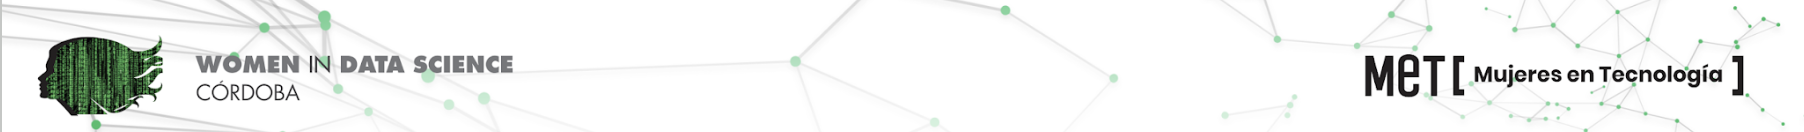

# Feature engineering & selection


-------------------------------

## Librerías

In [ ]:
!pip install --upgrade category_encoders

In [ ]:
#Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from random import shuffle
import pickle


import sys
sys.path.append('/content/')
#from transformers import *



import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.2f}'.format
sns.set_style("white")
sns.set_palette("flare")

## 01) Lectura de los datos

In [ ]:
%%time
df_train_eda = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQGoPiS3C4divKxs17LM3mhcG7L-JDXHYcIpX8sNET9wbLctqlS-V4ID0cwVMdEccdt8f6FitC2K0YC/pub?gid=2112906031&single=true&output=csv')
df_test_eda = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vS0IbI8WiSzaY-YJnZqQlBvhh7QJ-ynt751CixvxndlMpe0pBNQB0_2xyCkDvV7uh2vEWuqolIj_bQH/pub?gid=731515881&single=true&output=csv')

df_train_eda.head()

CPU times: user 98.3 ms, sys: 30.6 ms, total: 129 ms
Wall time: 2.7 s


,CustomerID,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,9571-EDEBV,San Diego,92119,"32.802959, -117.027095",32.80,-117.03,Male,No,Yes,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),98.65,6962.85,0
1,7562-GSUHK,Jamestown,95327,"37.84771, -120.486589",37.85,-120.49,Female,No,No,No,...,Yes,No,No,Yes,Month-to-month,Yes,Credit card (automatic),93.20,1573.70,1
2,2325-WINES,Littlerock,93543,"34.505273, -117.955054",34.51,-117.96,Female,No,No,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),104.05,3416.85,0
3,9381-NDKME,El Monte,91731,"34.079934, -118.046695",34.08,-118.05,Female,Yes,Yes,No,...,Yes,No,No,Yes,Month-to-month,Yes,Credit card (automatic),40.65,933.30,1
4,2164-SOQXL,Los Angeles,90043,"33.988543, -118.334081",33.99,-118.33,Female,No,Yes,Yes,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.05,406.05,0


In [ ]:
target = ['Churn Value']
var_id = ['CustomerID']
var_geo = ['Lat Long','Latitude','Longitude', 'Zip Code']
var_num = ['Monthly Charges', 'Total Charges', 'Tenure Months']


In [ ]:
df_train = df_train_eda.copy()

In [ ]:
df_train.set_index(var_id[0], inplace=True)
df_train.drop(var_geo + ['City'], axis = 1, inplace = True)

In [ ]:
var_cat = [i for i in df_train.columns if i not in var_num+var_geo+var_id+target]
var_cat

['Gender',
 'Senior Citizen',
 'Partner',
 'Dependents',
 'Phone Service',
 'Multiple Lines',
 'Internet Service',
 'Online Security',
 'Online Backup',
 'Device Protection',
 'Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Contract',
 'Paperless Billing',
 'Payment Method']

In [ ]:
df_train[var_cat] = df_train[var_cat].apply(lambda x: x.astype('category'))

## 02) Feature Engineering

#### Missing values

In [ ]:
# Chequeo missing values
na_cols=df_train.columns[df_train.isna().any()].tolist()

# Missing values summary
mv=pd.DataFrame(df_train[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(df_train),2)
mv.sort_values(by = 'Percentage_missing', ascending = False)

,Number_missing,Percentage_missing
Total Charges,11,0.20


In [ ]:
df_train[df_train['Total Charges'].isna()]['Tenure Months'].describe()

count   11.00
mean     0.00
std      0.00
min      0.00
25%      0.00
50%      0.00
75%      0.00
max      0.00
Name: Tenure Months, dtype: float64

In [ ]:
with pd.option_context('display.max_columns', None):
  display(df_train[df_train['Total Charges'].isna()])

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
CustomerID,,,,,,,,,,,,,,,,,,,,
2923-ARZLG,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,0
3213-VVOLG,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,0
3115-CZMZD,Male,No,No,No,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,0
7644-OMVMY,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,0
1371-DWPAZ,Female,No,Yes,No,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,0
2775-SEFEE,Male,No,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,0
4472-LVYGI,Female,No,Yes,No,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
4367-NUYAO,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,0
2520-SGTTA,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,0


In [ ]:
df_train[df_train['Tenure Months'] == 0].shape

(11, 20)

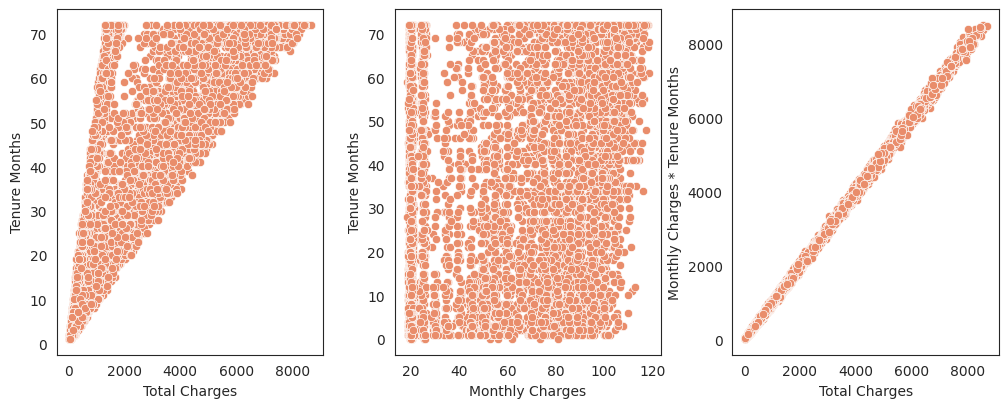

In [ ]:
# Scatter plot
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(10, 4))

sns.scatterplot(x = df_train['Total Charges'], y = df_train['Tenure Months'], ax=axs[0])
sns.scatterplot(x = df_train['Monthly Charges'], y = df_train['Tenure Months'], ax=axs[1])
sns.scatterplot(x = df_train['Total Charges'], y = (df_train['Monthly Charges'] * df_train['Tenure Months']), ax=axs[2])
plt.ylabel("Monthly Charges * Tenure Months")
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [ ]:
df_train.loc[:,'Total Charges'] = df_train.loc[:,'Total Charges'].fillna(0)

In [ ]:
df_train['Total Charges'].isna().sum()

0

#### Categorical variables enconding

In [ ]:
var_cat

['Gender',
 'Senior Citizen',
 'Partner',
 'Dependents',
 'Phone Service',
 'Multiple Lines',
 'Internet Service',
 'Online Security',
 'Online Backup',
 'Device Protection',
 'Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Contract',
 'Paperless Billing',
 'Payment Method']

In [ ]:
var_cat_2 = ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing']
var_cat_3_or_more = ['Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
                      'Streaming TV', 'Streaming Movies', 'Contract', 'Payment Method']

In [ ]:
for i in var_cat_2:
  if i == 'Gender':
    df_train[i] = df_train[i].map({'Male':1, 'Female':0})
  else:
    df_train[i] = df_train[i].map({'Yes':1, 'No':0})

df_train[var_cat_2] = df_train[var_cat_2].apply(lambda x: x.astype('int'))

In [ ]:
%%time
encoder = OneHotEncoder(cols=var_cat_3_or_more, use_cat_names=True,
                        return_df=True)

df_train_featureENG = encoder.fit_transform(df_train)

CPU times: user 167 ms, sys: 9 ms, total: 176 ms
Wall time: 181 ms


In [ ]:
df_train_featureENG.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines_Yes,Multiple Lines_No,Multiple Lines_No phone service,Internet Service_Fiber optic,...,Contract_Month-to-month,Contract_Two year,Paperless Billing,Payment Method_Credit card (automatic),Payment Method_Mailed check,Payment Method_Electronic check,Payment Method_Bank transfer (automatic),Monthly Charges,Total Charges,Churn Value
CustomerID,,,,,,,,,,,,,,,,,,,,,
9571-EDEBV,1,0,1,0,71,1,1,0,0,1,...,0,0,1,1,0,0,0,98.65,6962.85,0
7562-GSUHK,0,0,0,0,16,1,0,1,0,1,...,1,0,1,1,0,0,0,93.20,1573.70,1
2325-WINES,0,0,0,0,32,1,1,0,0,1,...,0,0,1,1,0,0,0,104.05,3416.85,0
9381-NDKME,0,1,1,0,24,0,0,0,1,0,...,1,0,1,1,0,0,0,40.65,933.30,1
2164-SOQXL,0,0,1,1,20,1,0,1,0,0,...,1,0,0,0,1,0,0,20.05,406.05,0


In [ ]:
cat_vars_full = [i for i in df_train_featureENG.columns if i not in var_num + target]

In [ ]:
df_train_featureENG[var_num + cat_vars_full + target].to_csv('train_set_processed_full.csv')

## 03) Feature Selecction

#### Variables altamente correlacionadas

In [ ]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [ ]:
au_corr = df_train_featureENG.corr().abs().unstack()
labels_to_drop = get_redundant_pairs(df_train_featureENG)
au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)

In [ ]:
df_corr = pd.DataFrame(au_corr).reset_index().rename(columns = {
              'level_0' : 'Feature_1', 'level_1' : 'Feature_2', 0: 'corr_abs'})

df_corr.head()

,Feature_1,Feature_2,corr_abs
0,Online Backup_No internet service,Streaming Movies_No internet service,1.00
1,Online Security_No internet service,Tech Support_No internet service,1.00
2,Online Security_No internet service,Device Protection_No internet service,1.00
3,Internet Service_No,Online Backup_No internet service,1.00
4,Internet Service_No,Device Protection_No internet service,1.00


In [ ]:
with pd.option_context('display.max_columns', None):
  display(df_corr[df_corr['corr_abs'] >= 0.8])

,Feature_1,Feature_2,corr_abs
0,Online Backup_No internet service,Streaming Movies_No internet service,1.00
1,Online Security_No internet service,Tech Support_No internet service,1.00
2,Online Security_No internet service,Device Protection_No internet service,1.00
3,Internet Service_No,Online Backup_No internet service,1.00
4,Internet Service_No,Device Protection_No internet service,1.00
5,Tech Support_No internet service,Streaming Movies_No internet service,1.00
6,Online Security_No internet service,Online Backup_No internet service,1.00
7,Tech Support_No internet service,Streaming TV_No internet service,1.00
8,Internet Service_No,Tech Support_No internet service,1.00
9,Streaming TV_No internet service,Streaming Movies_No internet service,1.00


In [ ]:
variables_a_exluir = df_corr[df_corr['corr_abs'] >= 0.8]['Feature_2'].to_list()
variables_a_exluir

['Streaming Movies_No internet service',
 'Tech Support_No internet service',
 'Device Protection_No internet service',
 'Online Backup_No internet service',
 'Device Protection_No internet service',
 'Streaming Movies_No internet service',
 'Online Backup_No internet service',
 'Streaming TV_No internet service',
 'Tech Support_No internet service',
 'Streaming Movies_No internet service',
 'Streaming TV_No internet service',
 'Streaming TV_No internet service',
 'Online Security_No internet service',
 'Tech Support_No internet service',
 'Streaming TV_No internet service',
 'Device Protection_No internet service',
 'Streaming Movies_No internet service',
 'Streaming TV_No internet service',
 'Streaming Movies_No internet service',
 'Streaming Movies_No internet service',
 'Tech Support_No internet service',
 'Multiple Lines_No phone service',
 'Total Charges',
 'Multiple Lines_No']

#### Variables continuas

##### Point Biserial Correlation

+info : https://www.statisticshowto.com/point-biserial-correlation/

In [ ]:
pbsc_dict = {}
for i in var_num:
    pbsc = pointbiserialr(df_train_featureENG.loc[:,i],df_train_featureENG.loc[:,target[0]])
    pbsc_dict[i] = [pbsc.correlation,np.abs(pbsc.correlation),pbsc.pvalue]

pbsc_df = pd.DataFrame.from_dict(data=pbsc_dict, orient='index')
pbsc_df.columns = ['corr','abscorr','pvalue']

In [ ]:
pbsc_df.loc[((pbsc_df['abscorr'] >= 0.1)),:].sort_values(by='abscorr', ascending=False).reset_index()


,index,corr,abscorr,pvalue
0,Tenure Months,-0.35,0.35,0.00
1,Total Charges,-0.20,0.20,0.00
2,Monthly Charges,0.19,0.19,0.00


##### Mutual Information

+info: https://www.blog.trainindata.com/mutual-information-with-python/

In [ ]:
mi_cont = mutual_info_classif(df_train[var_num], df_train[target[0]])
mi_df_cont = pd.DataFrame(mi_cont,var_num)
mi_df_cont.columns = ['mutual_info']
mi_df_cont.sort_values(by='mutual_info', ascending=False).reset_index()


,index,mutual_info
0,Tenure Months,0.08
1,Total Charges,0.04
2,Monthly Charges,0.04


#### Variables categoricas

+info:https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

#####  Cramer’s V

In [ ]:
#### Variables continuas

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [ ]:
cat_vars = [i for i in df_train_featureENG.columns if i not in var_num + variables_a_exluir]

In [ ]:
cat_vars

['Gender',
 'Senior Citizen',
 'Partner',
 'Dependents',
 'Phone Service',
 'Multiple Lines_Yes',
 'Internet Service_Fiber optic',
 'Internet Service_DSL',
 'Internet Service_No',
 'Online Security_No',
 'Online Security_Yes',
 'Online Backup_No',
 'Online Backup_Yes',
 'Device Protection_Yes',
 'Device Protection_No',
 'Tech Support_No',
 'Tech Support_Yes',
 'Streaming TV_Yes',
 'Streaming TV_No',
 'Streaming Movies_Yes',
 'Streaming Movies_No',
 'Contract_One year',
 'Contract_Month-to-month',
 'Contract_Two year',
 'Paperless Billing',
 'Payment Method_Credit card (automatic)',
 'Payment Method_Mailed check',
 'Payment Method_Electronic check',
 'Payment Method_Bank transfer (automatic)',
 'Churn Value']

In [ ]:
cat_vars.reverse()

In [ ]:
df_asoc_cat = pd.DataFrame(columns=['Feature_1', 'Feature_2', 'cramers_v'])

for i in cat_vars:
    cat_vars.remove(i)

    for j in cat_vars:
      row = {
            'Feature_1': i,
            'Feature_2': j,
            'cramers_v': np.round((cramers_v(df_train_featureENG[i], df_train_featureENG[j])),3)
            }

      df_asoc_cat = df_asoc_cat.append(row, ignore_index=True)

In [ ]:
df_asoc_cat

,Feature_1,Feature_2,cramers_v
0,Churn Value,Payment Method_Bank transfer (automatic),0.11
1,Churn Value,Payment Method_Electronic check,0.30
2,Churn Value,Payment Method_Mailed check,0.09
3,Churn Value,Payment Method_Credit card (automatic),0.14
4,Churn Value,Paperless Billing,0.20
...,...,...,...
325,Senior Citizen,Internet Service_No,0.19
326,Senior Citizen,Internet Service_Fiber optic,0.25
327,Senior Citizen,Phone Service,0.00
328,Senior Citizen,Partner,0.01


In [ ]:
df_asoc_cat[(df_asoc_cat['Feature_1'] == 'Churn Value') & (df_asoc_cat['cramers_v'] >= 0.20)].sort_values(by = 'cramers_v', ascending = False)

,Feature_1,Feature_2,cramers_v
6,Churn Value,Contract_Month-to-month,0.40
19,Churn Value,Online Security_No,0.34
13,Churn Value,Tech Support_No,0.34
5,Churn Value,Contract_Two year,0.30
22,Churn Value,Internet Service_Fiber optic,0.30
1,Churn Value,Payment Method_Electronic check,0.30
17,Churn Value,Online Backup_No,0.26
14,Churn Value,Device Protection_No,0.25
25,Churn Value,Dependents,0.24
20,Churn Value,Internet Service_No,0.23


In [ ]:
df_asoc_cat[(df_asoc_cat['Feature_1'] != 'Churn Value') & (df_asoc_cat['cramers_v'] > 0.8)].sort_values(by = 'cramers_v', ascending = False)

,Feature_1,Feature_2,cramers_v


In [ ]:
df_asoc_cat[(df_asoc_cat['Feature_1'] == 'Churn Value') & (df_asoc_cat['cramers_v'] < 0.20)].sort_values(by = 'cramers_v', ascending = False)

,Feature_1,Feature_2,cramers_v
4,Churn Value,Paperless Billing,0.20
7,Churn Value,Contract_One year,0.17
18,Churn Value,Online Security_Yes,0.17
12,Churn Value,Tech Support_Yes,0.16
27,Churn Value,Senior Citizen,0.15
26,Churn Value,Partner,0.15
3,Churn Value,Payment Method_Credit card (automatic),0.14
8,Churn Value,Streaming Movies_No,0.14
10,Churn Value,Streaming TV_No,0.13
21,Churn Value,Internet Service_DSL,0.12


In [ ]:
['Senior Citizen', 'Partner', 'Paperless Billing']

['Senior Citizen', 'Partner', 'Paperless Billing']

In [ ]:
df_asoc_cat[(df_asoc_cat['Feature_1'] == 'Churn Value') & (df_asoc_cat['cramers_v'] >= 0.20)]['Feature_2'].to_list()

['Payment Method_Electronic check',
 'Contract_Two year',
 'Contract_Month-to-month',
 'Tech Support_No',
 'Device Protection_No',
 'Online Backup_No',
 'Online Security_No',
 'Internet Service_No',
 'Internet Service_Fiber optic',
 'Dependents']

In [ ]:
features_finales = ['Tenure Months',
                    'Monthly Charges',
                    'Payment Method_Electronic check',
                    'Contract_Two year',
                    'Contract_Month-to-month',
                    'Tech Support_No',
                    'Device Protection_No',
                    'Online Backup_No',
                    'Online Security_No',
                    'Internet Service_No',
                    'Internet Service_Fiber optic',
                    'Dependents',
                    'Senior Citizen',
                    'Partner',
                    'Paperless Billing']

In [ ]:
shuffle(features_finales)


In [ ]:
len(features_finales)

15

In [ ]:
features_finales

['Online Security_No',
 'Monthly Charges',
 'Tenure Months',
 'Internet Service_Fiber optic',
 'Partner',
 'Payment Method_Electronic check',
 'Dependents',
 'Senior Citizen',
 'Internet Service_No',
 'Contract_Two year',
 'Tech Support_No',
 'Contract_Month-to-month',
 'Device Protection_No',
 'Paperless Billing',
 'Online Backup_No']

+info: [Boruta Explained Exactly How You Wished Someone Explained to You](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a)

## 03) Preprocesamiento

In [ ]:
features = {
    'all' : ['Dependents',
                    'Internet Service_Fiber optic',
                    'Monthly Charges',
                    'Contract_Two year',
                    'Contract_Month-to-month',
                    'Online Security_No',
                    'Tenure Months',
                    'Device Protection_No',
                    'Paperless Billing',
                    'Payment Method_Electronic check',
                    'Internet Service_No',
                    'Senior Citizen',
                    'Partner',
                    'Online Backup_No',
                    'Tech Support_No'],
    'numerical' : ['Tenure Months',
                    'Monthly Charges',
                    'Payment Method'],
    'dummy' : ['Senior Citizen',
                    'Partner',
                    'Dependents',
                    'Paperless Billing'],
    'categorical' : ['Internet Service',
                     'Contract',
                     'Online Security',
                     'Device Protection',
                     'Payment Method',
                     'Online Backup',
                     'Tech Support']
}

In [ ]:
'''
class DummyVars(BaseEstimator, TransformerMixin):
    def __init__(self, dummy_features):
        self.dummy_features = dummy_features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for v in self.dummy_features:
            X[v] = X[v].map({'Yes':1, 'No':0})
        X[self.dummy_features] = X[self.dummy_features].apply(lambda y: y.astype('int'))
        return X

class DataTypeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features):
        self.cat_features = cat_features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for v in self.cat_features:
            X[v] = X[v].astype("category")
        return X

class CustomOHE(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features, encoder_ce):
      self.cat_features = cat_features
      self.encoder_ce = encoder_ce

    def fit(self, X, y=None):
      return self

    def transform(self, X, y=None):
      X = self.encoder_ce.fit_transform(X)
      return X

class FeaturesSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features = None):
        self.features = features

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        if self.features:
            X = X[self.features]
        return X
'''

In [ ]:
dummy_trans = Pipeline([
    ('dummy_map', DummyVars(dummy_features = features['dummy']))
])

correct_type_cat = Pipeline([
    ('correct_type_cat', DataTypeTransformer(cat_features = features['categorical']))
])

CustomOHE = Pipeline([
    ('custom_ohe', CustomOHE(cat_features = features['categorical'], encoder_ce = OneHotEncoder(
                                    cols=features['categorical'],
                                    use_cat_names=True,
                                    return_df=True)))
])

features_selector = Pipeline([
    ('features_selector', FeaturesSelector(features = features['all']))
])



In [ ]:
encoding_pipeline = Pipeline(
        steps=[
            ('dummy_map', dummy_trans),
            ('correct_type_cat', correct_type_cat),
            ('custom_ohe', CustomOHE),
            ('features_selector', features_selector)
        ]
    )

In [ ]:
df_train_aux = df_train_eda.copy()
df_train_aux.set_index(var_id[0], inplace=True)

In [ ]:
df_train_transformed = pd.DataFrame(encoding_pipeline.fit_transform(df_train_aux),columns= features['all'])
df_train_transformed.head()

,Dependents,Internet Service_Fiber optic,Monthly Charges,Contract_Two year,Contract_Month-to-month,Online Security_No,Tenure Months,Device Protection_No,Paperless Billing,Payment Method_Electronic check,Internet Service_No,Senior Citizen,Partner,Online Backup_No,Tech Support_No
CustomerID,,,,,,,,,,,,,,,
9571-EDEBV,0,1,98.65,0,0,1,71,0,1,0,0,0,1,1,1
7562-GSUHK,0,1,93.20,0,1,1,16,0,1,0,0,0,0,0,1
2325-WINES,0,1,104.05,0,0,1,32,0,1,0,0,0,0,0,1
9381-NDKME,0,0,40.65,0,1,1,24,0,1,0,0,1,1,1,1
2164-SOQXL,1,0,20.05,0,1,0,20,0,0,0,1,0,1,0,0


In [ ]:
#Guardamos el pipeline
pickle.dump(encoding_pipeline, open('preprocessing_pipeline.pkl', 'wb'))

In [ ]:
with open('preprocessing_pipeline.pkl', 'rb') as fp:
    encoding_pipeline_pkl = pickle.load(fp)

In [ ]:
df_train_aux = df_train_eda.copy()
df_train_aux.set_index(var_id[0], inplace=True)

In [ ]:
df_train_transformed_pkl = pd.DataFrame(encoding_pipeline_pkl.fit_transform(df_train_aux),columns= features['all'])
df_train_transformed_pkl.head()

,Dependents,Internet Service_Fiber optic,Monthly Charges,Contract_Two year,Contract_Month-to-month,Online Security_No,Tenure Months,Device Protection_No,Paperless Billing,Payment Method_Electronic check,Internet Service_No,Senior Citizen,Partner,Online Backup_No,Tech Support_No
CustomerID,,,,,,,,,,,,,,,
9571-EDEBV,0,1,98.65,0,0,1,71,0,1,0,0,0,1,1,1
7562-GSUHK,0,1,93.20,0,1,1,16,0,1,0,0,0,0,0,1
2325-WINES,0,1,104.05,0,0,1,32,0,1,0,0,0,0,0,1
9381-NDKME,0,0,40.65,0,1,1,24,0,1,0,0,1,1,1,1
2164-SOQXL,1,0,20.05,0,1,0,20,0,0,0,1,0,1,0,0


## 04) Export

In [ ]:
df_test_aux = df_test_eda.copy()
df_test_aux.set_index(var_id[0], inplace=True)

In [ ]:
df_test_transformed = pd.DataFrame(encoding_pipeline.fit_transform(df_test_aux),columns= features['all'])
df_test_transformed.head()

,Dependents,Internet Service_Fiber optic,Monthly Charges,Contract_Two year,Contract_Month-to-month,Online Security_No,Tenure Months,Device Protection_No,Paperless Billing,Payment Method_Electronic check,Internet Service_No,Senior Citizen,Partner,Online Backup_No,Tech Support_No
CustomerID,,,,,,,,,,,,,,,
2189-WWOEW,0,1,85.90,0,1,1,15,1,1,0,0,0,0,0,1
2446-ZKVAF,0,0,56.80,0,1,1,18,1,0,0,0,0,1,0,1
4986-MXSFP,0,0,20.00,0,1,0,2,0,1,0,1,0,0,0,0
5868-YWPDW,0,1,84.20,0,1,1,6,1,1,1,0,1,1,0,1
9412-GHEEC,0,1,104.80,0,1,1,40,0,0,0,0,0,0,1,0


In [ ]:
df_train_transformed.to_csv('train_set_processed.csv')
df_test_transformed.to_csv('test_set_processed.csv')